# Plot a summary of whole PPE
This notebook plots every PPE member together. First, the PPE is split into three groups:
- formed Sc but did not transition
- transitioned with low mean RWP (< 7 g m^{-2})
- transitioned with high mean RWP (> 7 g m^{-2})

Then the timeseries of the model outputs of interest are averaged across the subsets to show the subset median as a line and the min/max as a shaded envelope.

NB:- This notebook was rewritten with the assistance AI (Google Gemini) because the original script was lost :( 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("py_scripts")
import cloud_lib as cl
import ppe_class_lib as ppe_lib
import xarray as xr
import string

In [2]:
SMALL_SIZE = 10
LARGE_SIZE = 14
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE-0.5)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

In [5]:
sc_thresh = 0.9
cu_thresh = 0.55
ppe = ppe_lib.Ensemble(sc_thresh, cu_thresh, include_spinup=False, use_sc_beginning_vals=True, find_ssts=True, use_ic_ensembles=True)

ppe_set = ppe.member_sc_keys
print("Loading new processed ds")
for i, key in enumerate(ppe_set):
    member = vars(ppe)[key]
    spatial_sum = member.ds.surface_precip.sum(dim=['x', 'y'])
    member.ds["accum_surface_precip"] = spatial_sum.cumsum(dim='time_coarse')

Initiating ensemble...
Loading members


/home/users/eers/sct/py_scripts/ppe_class_lib.py:280: RuntimeWarning: Mean of empty slice
  cf_mean = np.nanmean(cf_timeseries_nan_mask, axis=0)
/home/users/eers/sct/py_scripts/ppe_class_lib.py:281: RuntimeWarning: Mean of empty slice
  cf_times_mean = np.nanmean(cf_times_nan_mask, axis=0)
/home/users/eers/sct/py_scripts/ppe_class_lib.py:291: RuntimeWarning: Mean of empty slice
  rwp_mean = np.nanmean(rwp_timeseries_nan_mask, axis=0)
/home/users/eers/sct/py_scripts/ppe_class_lib.py:292: RuntimeWarning: Mean of empty slice
  rwp_times_mean = np.nanmean(rwp_times_nan_mask, axis=0)
/home/users/eers/sct/py_scripts/ppe_class_lib.py:280: RuntimeWarning: Mean of empty slice
  cf_mean = np.nanmean(cf_timeseries_nan_mask, axis=0)
/home/users/eers/sct/py_scripts/ppe_class_lib.py:281: RuntimeWarning: Mean of empty slice
  cf_times_mean = np.nanmean(cf_times_nan_mask, axis=0)
/home/users/eers/sct/py_scripts/ppe_class_lib.py:291: RuntimeWarning: Mean of empty slice
  rwp_mean = np.nanmean(rwp_times

Ensemble initialised.
Loading new processed ds


In [6]:
SST_dict = ppe_lib.get_sst()
SST_dict["surface_boundary_input_times"] = SST_dict["surface_boundary_input_times"]/3600

In [7]:
# Define the category names and their corresponding colors for the plot
CATEGORIES = {
    'No transition': 'mediumseagreen',
    'Low mean R': "#c83737ff",
    'High mean R': "#2d93adff"
}

# Define the rain threshold based on criteria
RAIN_THRESHOLD = 7
category_titles = ['Does not transition from Sc','Low mean R (< 7 g m$^{-2}$)','High mean R (> 7 g m$^{-2}$)']

In [8]:
def group_and_calculate_stats_from_class(ppe_instance, variable_name, time_name):
    """
    Groups individual ensemble datasets (accessed as ppe.emX attributes) and calculates 
    the mean, max, and min time series for each category for the specified variable.

    :param ppe_instance: An instance of the ppe class (e.g., your_ppe_object).
    :param variable_name: The name of the variable to analyze (e.g., 'SST').
    :return: A dictionary of statistics, keyed by category name.
    """
    # 1. Initialize storage for data arrays, grouped by category
    grouped_data = {category: np.full((len(ppe_instance.member_sc_keys), 250), np.nan) for category in CATEGORIES}

    # 2. Identify the ensemble member attributes (e.g., 'em0', 'em1', ...)
    member_attributes = [attr for attr in vars(ppe_instance) if attr in ppe.member_sc_keys]
    
    # 3. Iterate through each ensemble member dataset (ds_member)
    padded_time_array = np.full((len(ppe_instance.member_sc_keys), 250), np.nan)
    for i, attr_name in enumerate(member_attributes):
        member = getattr(ppe_instance, attr_name)

        # Check if the attribute is an xarray Dataset
        if not isinstance(member.ds, xr.Dataset):
            print(f"Warning: Attribute '{attr_name}' is not an xarray.Dataset. Skipping.")
            continue
            
        # --- Grouping Logic ----
        
        # Access the grouping attributes/variables. 
        did_transition = True if member.cu else False
        
        if did_transition:
            mean_rwp = member.rwp_mean.item()
        
        category = None
        if not did_transition:
            # a) No transition
            category = 'No transition'
        elif did_transition and mean_rwp > RAIN_THRESHOLD:
            # b) High mean rain (RWP > 7)
            category = 'High mean R'
        elif did_transition and mean_rwp <= RAIN_THRESHOLD:
            # c) Low mean rain (RWP <= 7)
            category = 'Low mean R'

        if variable_name in ["inversion_height", "zlcl"]:
            data = member.ds[variable_name].values*1e-3
        elif variable_name == "rwp":
            data = member.ds[variable_name].values*1e3
        elif variable_name == "accumulation_number_bl":
            data = member.ds[variable_name].values*1e-6
        else:
            data = member.ds[variable_name].values
            
        if category:
            # Add the DataArray for the target variable to the correct category list
            grouped_data[category][i,0:len(member.ds[variable_name])] = data
            
        padded_time_array[i,0:len(member.ds[variable_name])] = member.ds[time_name].values


    # 4. Calculate ensemble statistics for each group
    category_stats = {}
    for category, da_list in grouped_data.items():
        mean_time_array = np.nanmean(padded_time_array, axis=0)
        mean_output = np.nanmedian(grouped_data[category], axis=0)
        max_output = np.nanmax(grouped_data[category], axis=0)
        min_output = np.nanmin(grouped_data[category], axis=0)
        global_valid_indices = ~np.isnan(mean_time_array)

        category_stats[category] = {
            'mean': mean_output[global_valid_indices],
            'min': min_output[global_valid_indices],
            'max': max_output[global_valid_indices],
            'color': CATEGORIES[category],
            'time': mean_time_array[global_valid_indices]
        }
        
    return category_stats

In [9]:
def plot_variable_timeseries(ax, variable_stats, variable_name, ylabel, letter, xlabel='Time from simulation start (h)'):
    """
    Plots the ensemble statistics for one variable onto a given axis.

    :param ax: The matplotlib Axes object to plot onto.
    :param variable_stats: The output dictionary from calculate_ensemble_stats.
    :param variable_name: The name of the variable for the title.
    :param ylabel: The y-axis label (with units).
    :param xlabel: The x-axis label.
    """
    category_handles = []
    for category, stats in variable_stats.items():
        time = stats['time']
        color = stats['color']
        
        pl, = ax.plot(stats['time'], 
                stats['mean'],
                label=category,
                color=color,
                linewidth=2
               )
        
        # 2. Plot the shading (min/max)
        fb = ax.fill_between(
            time,
            stats['min'], 
            stats['max'], 
            color=color, 
            alpha=0.2, 
        )
        category_handles.append((pl, fb))
        
    # Set labels, title, and grid
    ax.set_title(f'({letter}) {variable_name}')
    ax.set_ylabel(ylabel)
    ax.grid(axis='y', linestyle='--')
    ax.set_xlabel('')
    return category_handles

In [10]:
def create_full_figure(ppe_instance):
    """
    Creates the complete 3x3 figure by calling the data processing function.
    """
    # Define the variables and their labels/units 
    plot_info = [
        ('SST', 'sst_time', 'Sea-surface temperature', 'K', (293,300)),
        ('inversion_height', 'time_mid', 'Inversion height', 'km', (0,2.8)),
        ('zlcl', 'time_mid','Lifting condensation level', 'km', (0,2.8)),
        ('decoupling', 'time_coarse', 'Decoupling factor', '',(0,4)),
        ('accum_surface_precip', 'time_coarse', 'Accumulated surface precip.', 'mm', (0,23)),
        ('cloud_frac', 'time_coarse', 'Cloud fraction', '', (0,1)),
        ('cloudy_lwp', 'time_coarse', 'Liquid water path', 'g m$^{-2}$', (0,310)),
        ('rwp', 'time_fine', 'Rain water path', 'g m$^{-2}$', (0,74)),
        ('accumulation_number_bl', 'time_coarse', 'BL Accum. num.', 'cm$^{-3}$', (0,420))
    ]
    
    # Create the 3x3 figure with shared x-axis
    fig, axes = plt.subplots(3, 3, figsize=(12, 7))
    axes = axes.flatten()

    for i, (var_key, time_key, title, units, ylims) in enumerate(plot_info):
        print(var_key)
        ax = axes[i]

        # Set labels and plot
        xlabel = 'Time from simulation start (h)' if i >= 6 else ''
        ax.set_xticks(np.arange(0,72,10))

        if var_key=="SST":
            ax.plot(SST_dict["surface_boundary_input_times"], SST_dict["surface_temperatures"],color='black')
            ax.set_title("(a) Sea-surface temperature")
            cl.add_diurnal(ppe_instance.em0.ds, ax, ylims)
            ax.set_ylim(ylims)
            ax.set_xlim((0,72))
            ax.set_ylabel(units)
            ax.set_yticks([294, 296, 298, 300])
            continue

        # 1. Calculate the statistics for the current variable using the class instance
        variable_stats = group_and_calculate_stats_from_class(ppe_instance, var_key, time_key)
        
        if not variable_stats:
            ax.set_title(f'({chr(97+i)}) {title}', loc='left', color='gray')
            continue

        # 2. Plot the results
        category_handles = plot_variable_timeseries(
            ax, 
            variable_stats, 
            title, 
            units,
            string.ascii_lowercase[i],
            xlabel=xlabel
        )
        ax.set_xlim(0,72)
        cl.add_diurnal(ppe_instance.em0.ds, ax, ylims)
        ax.set_ylim(ylims)

    fig.legend(category_handles, category_titles, loc='lower center', ncol=3, title='', frameon=False)
    axes[-2].set_xlabel(xlabel)
    
    plt.tight_layout(rect=[0, 0.05, 1, 1]) 
    return fig

SST
inversion_height


/tmp/ipykernel_1099/3810697400.py:66: RuntimeWarning: Mean of empty slice
  mean_time_array = np.nanmean(padded_time_array, axis=0)
/tmp/ipykernel_1099/3810697400.py:67: RuntimeWarning: All-NaN slice encountered
  mean_output = np.nanmedian(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:68: RuntimeWarning: All-NaN slice encountered
  max_output = np.nanmax(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:69: RuntimeWarning: All-NaN slice encountered
  min_output = np.nanmin(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:66: RuntimeWarning: Mean of empty slice
  mean_time_array = np.nanmean(padded_time_array, axis=0)
/tmp/ipykernel_1099/3810697400.py:67: RuntimeWarning: All-NaN slice encountered
  mean_output = np.nanmedian(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:68: RuntimeWarning: All-NaN slice encountered
  max_output = np.nanmax(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:69: Runti

zlcl
decoupling
accum_surface_precip
cloud_frac


/tmp/ipykernel_1099/3810697400.py:66: RuntimeWarning: Mean of empty slice
  mean_time_array = np.nanmean(padded_time_array, axis=0)
/tmp/ipykernel_1099/3810697400.py:67: RuntimeWarning: All-NaN slice encountered
  mean_output = np.nanmedian(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:68: RuntimeWarning: All-NaN slice encountered
  max_output = np.nanmax(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:69: RuntimeWarning: All-NaN slice encountered
  min_output = np.nanmin(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:66: RuntimeWarning: Mean of empty slice
  mean_time_array = np.nanmean(padded_time_array, axis=0)
/tmp/ipykernel_1099/3810697400.py:67: RuntimeWarning: All-NaN slice encountered
  mean_output = np.nanmedian(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:68: RuntimeWarning: All-NaN slice encountered
  max_output = np.nanmax(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:69: Runti

cloudy_lwp
rwp


/tmp/ipykernel_1099/3810697400.py:66: RuntimeWarning: Mean of empty slice
  mean_time_array = np.nanmean(padded_time_array, axis=0)
/tmp/ipykernel_1099/3810697400.py:67: RuntimeWarning: All-NaN slice encountered
  mean_output = np.nanmedian(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:68: RuntimeWarning: All-NaN slice encountered
  max_output = np.nanmax(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:69: RuntimeWarning: All-NaN slice encountered
  min_output = np.nanmin(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:66: RuntimeWarning: Mean of empty slice
  mean_time_array = np.nanmean(padded_time_array, axis=0)
/tmp/ipykernel_1099/3810697400.py:67: RuntimeWarning: All-NaN slice encountered
  mean_output = np.nanmedian(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:68: RuntimeWarning: All-NaN slice encountered
  max_output = np.nanmax(grouped_data[category], axis=0)
/tmp/ipykernel_1099/3810697400.py:69: Runti

accumulation_number_bl


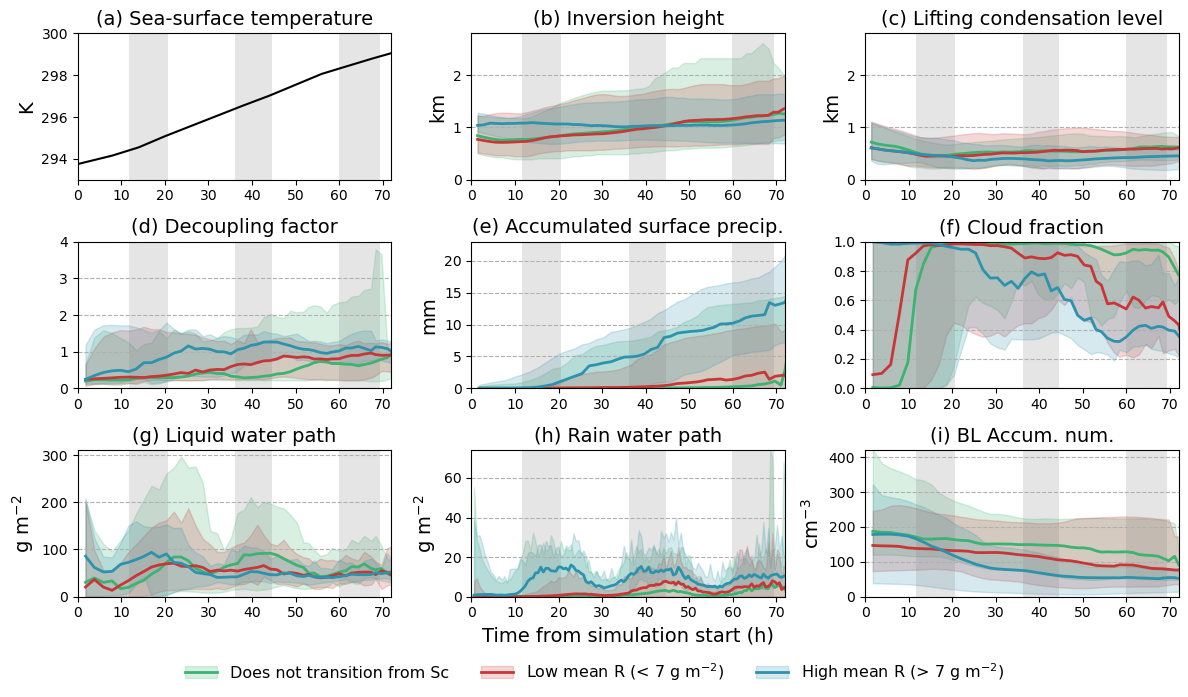

In [11]:
fig = create_full_figure(ppe)
# fig.savefig("./figures/ppe_summary_new.png",facecolor='white',dpi=300)
# fig.savefig("./figures/ppe_summary_new.pdf",facecolor='white',dpi=300)